## Empirical dataset creation

In [40]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from typing import List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import sort_transcript
from evaluation import evaluate_cycle_prediction
from transcript_sorting import sort_transcript, create_reduced_spacer_transcript, sort_transcript_reduced_spacers

In [5]:
train_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\empirical_train_dataset_v6.pkl"
test_dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\datasets\empirical\full_empirical_test_dataset_v5_payload_seq.pkl"
motif_search_barcoded = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\motif_search_barcoded.csv"

In [6]:
train_df = pd.read_pickle(train_dataset_path)

In [10]:
orientation_df = pd.read_csv(motif_search_barcoded)

In [11]:
cols_to_add = [col for col in orientation_df.columns if col not in train_df.columns or col == 'read_id']

In [12]:
merged_df = pd.merge(train_df, orientation_df[cols_to_add], on='read_id')

In [13]:
train_df

,ONT_Barcode,HW_Address,Payload,Library_Motifs,read_id,squiggle,Motifs,Spacer_Sequence,Payload_Sequence
0,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[3, 5], [1], [1], [4], [5], [], [], []]",0804c886-cd0a-4ece-87ee-adb529974699,"[0.7250000000000001, 0.7350000000000001, 0.752...","[1, 3, 5, 1, 1, 4, 5]","[11, 3, 11, 11, 5, 11, 12, 1, 12, 13, 1, 13, 1...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1..."
1,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[5], [1], [], [7], [7], [8], [], []]",0f041c54-7071-49d3-8ae2-7a1bf25525ab,"[0.525, 0.4845238095238096, 0.5035714285714287...","[5, 1, 1, 7, 7, 7, 8]","[11, 5, 11, 12, 1, 12, 14, 7, 14, 15, 7, 15, 1...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1..."
2,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[], [2], [], [4], [5], [6], [5], []]",1361a5db-d135-4e98-bb49-7a53c8d72991,"[0.6675799086757991, 0.5095890410958903, 0.515...","[1, 1, 2, 7, 4, 5, 6, 5]","[12, 2, 12, 14, 4, 14, 15, 5, 15, 16, 6, 16, 1...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1..."
3,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[4], [], [4], [6], [], [6], [], []]",1b4284d2-bee2-4a15-abab-aad861447308,"[0.6846153846153846, 0.5461538461538461, 0.549...","[1, 1, 1, 4, 4, 6, 6]","[11, 4, 11, 13, 4, 13, 14, 6, 14, 16, 6, 16]","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1..."
4,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[2], [2], [1], [4], [8], [3], [3], [5]]",1cc7b7bb-cd90-485f-b744-cf846d566675,"[0.7113163972286374, 0.6628175519630484, 0.662...","[1, 2, 2, 1, 4, 8, 3, 3, 5]","[11, 2, 11, 12, 2, 12, 13, 1, 13, 14, 4, 14, 1...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1..."
...,...,...,...,...,...,...,...,...,...
23934,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[], [4], [1], [8], [6], [], [6], [7]]",e1d6beff-c03a-4bab-bfa4-a4175da41be1,"[0.5864553314121037, 0.49279538904899134, 0.52...","[8, 4, 1, 8, 6, 6, 7]","[12, 4, 12, 13, 1, 13, 14, 8, 14, 15, 6, 15, 1...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1..."
23935,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[], [4], [2], [5], [1], [], [5], []]",ea27bf18-d3df-4b52-8f9e-98d23ce43b15,"[0.6136054421768707, 0.6054421768707482, 0.621...","[8, 8, 4, 2, 5, 1, 5]","[12, 4, 12, 13, 2, 13, 14, 5, 14, 15, 1, 15, 1...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1..."
23936,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[3], [2], [4], [5], [3], [], [], [2]]",f566dadf-dd54-4efe-8d04-94f6dededac8,"[0.7506172839506173, 0.5851851851851851, 0.612...","[8, 3, 2, 4, 5, 3, 2]","[11, 3, 11, 12, 2, 12, 13, 4, 13, 14, 5, 14, 1...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1..."
23937,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[4], [2], [4], [8], [], [1], [6], []]",f6e6ff66-98f2-4cca-9840-cedb55ee7f9d,"[0.6947115384615384, 0.7680288461538461, 0.728...","[8, 4, 2, 4, 8, 1, 6]","[11, 4, 11, 12, 2, 12, 13, 4, 13, 14, 8, 14, 1...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1..."


In [14]:
def get_df_for_barcode_address(df: pd.DataFrame, barcode: int, address: str) -> pd.DataFrame:
    return df.loc[
        (df['ONT_Barcode'] == barcode) & 
        (df['HW_Address'] == address) &
        (df['orientation'].str.startswith('+'))

    ]

def sort_sequences_by_length(spacer_sequences: List[str], read_ids: List[str]):

    sorted_indices = sorted(
        range(len(spacer_sequences)), key=lambda i: len(spacer_sequences[i]), reverse=True)
    
    return [spacer_sequences[ind] for ind in sorted_indices], [read_ids[ind] for ind in sorted_indices]
        

def get_longest_sequence(spacer_sequences: List[str], read_ids: List[str]):
    max_len = 0
    max_seq = 0
    read_id = ""
    for seq, r_id in zip(spacer_sequences, read_ids):
        if len(seq) > max_len:
            max_len = len(seq)
            max_seq = seq
            read_id = r_id

    return max_seq, read_id

In [15]:

seqs_arr = []
read_ids_arr = []

for barcode in tqdm(merged_df['ONT_Barcode'].unique()):
    for address in merged_df['HW_Address'].unique():
        selected_df = get_df_for_barcode_address(
            df=merged_df, barcode=barcode, address=address)
        
        #seq, read_id = get_longest_sequence(
        #    selected_df['Spacer_Sequence'], selected_df['read_id'])
        
        seqs, read_ids = sort_sequences_by_length(
            selected_df['Spacer_Sequence'].tolist(), selected_df['read_id'].tolist())

        
        seqs_arr.extend(seqs[:10])
        read_ids_arr.extend(read_ids[:10])


  0%|          | 0/16 [00:00<?, ?it/s]

In [26]:
def create_reduced_spacer_transcript(motif_seq: List[int]) -> List[int]:
    """ 12 4 12 12 3 12 -> 12 4 2 3 4 12 13 2 4 5 3 13"""

    seq = []
    str_seq = " ".join([str(i) for i in motif_seq])
    cycle_transcript = sort_transcript(str_seq)

    for ind, i in enumerate(cycle_transcript):
        if len(i) == 0:
            continue
        
        seq.append(ind + 11)
        seq.extend(list(set(i)))
        seq.append(ind + 11)

    return seq
    

In [29]:
for i in seqs_arr:
    sorted_transcript = sort_transcript(i)
    reduced_spacers_str = create_reduced_spacer_transcript(i)
    reduced_spacers_transcript = sort_transcript_reduced_spacers(reduced_spacers_str)

    print(sorted_transcript)
    print(reduced_spacers_transcript)
    print()
    

AttributeError: 'list' object has no attribute 'split'

(array([   9.,   13.,   34., 4810., 3574.,  977.,  332.,   20.,    9.,
           5.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

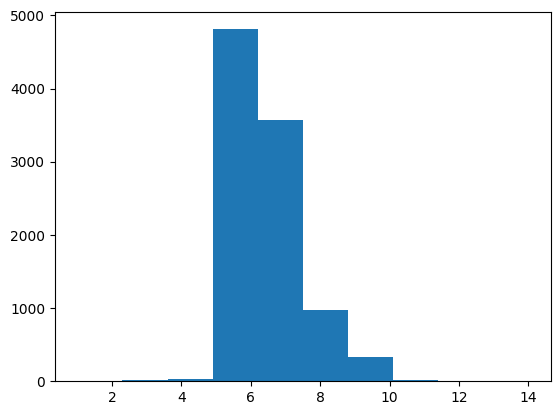

In [27]:
plt.hist([len(i)/3 for i in seqs_arr])

In [28]:
filtered_df = merged_df[merged_df['read_id'].isin(read_ids_arr)]

In [29]:
filtered_df = filtered_df.rename(columns={'Spacer_Sequence': 'motif_seq'})

In [30]:
filtered_df['motif_seq'] = filtered_df['motif_seq'].apply(create_reduced_spacer_transcript)

In [60]:
filtered_df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\pickled_datasets\cleaned_+_reduced_spacers_5_per_read.pkl")

In [7]:
filtered_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\pickled_datasets\cleaned_+_reduced_spacers_5_per_cycle.pkl")


filtered_df

,ONT_Barcode,HW_Address,Payload,Library_Motifs,read_id,squiggle,Motifs,motif_seq,Payload_Sequence,orientation,start_end,library_motif
0,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[3, 5], [1], [1], [4], [5], [], [], []]",0804c886-cd0a-4ece-87ee-adb529974699,"[0.7250000000000001, 0.7350000000000001, 0.752...","[1, 3, 5, 1, 1, 4, 5]","[11, 3, 5, 11, 12, 1, 1, 4, 5, 12, 13, 13, 14,...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1...",+|+|+|+|+|+|+,373-422|150-199|423-472|472-521|246-295|572-62...,ltm8_2x1|ltm8_3x3|ltm8_3x5|ltm8_4x1|ltm8_5x1|l...
4,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[2], [2], [1], [4], [8], [3], [3], [5]]",1cc7b7bb-cd90-485f-b744-cf846d566675,"[0.7113163972286374, 0.6628175519630484, 0.662...","[1, 2, 2, 1, 4, 8, 3, 3, 5]","[11, 2, 11, 12, 2, 1, 4, 8, 12, 13, 3, 3, 5, 1...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1...",+|+|+|+|+|+|+|+|+,116-165|215-264|265-314|315-364|365-414|415-46...,ltm8_1x1|ltm8_3x2|ltm8_4x2|ltm8_5x1|ltm8_6x4|l...
10,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[2], [7], [], [7], [5], [6], [5], [6]]",446f24b0-6392-4005-b9c6-5ef7c8cece73,"[0.5530460261262361, 0.5570748382370895, 0.555...","[2, 7, 7, 5, 6, 5, 6]","[11, 2, 11, 12, 7, 7, 5, 6, 12, 13, 5, 6, 13, ...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1...",+|+|+|+|+|+|+,194-243|244-293|339-388|389-438|439-488|489-53...,ltm8_3x2|ltm8_4x7|ltm8_6x7|ltm8_7x5|ltm8_8x6|l...
20,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[5], [1], [6], [4], [7], [6], [], [6]]",c4eb07e6-e34a-4321-9bbd-ee527f7667d1,"[0.5586619460383347, 0.5491392992308631, 0.549...","[5, 1, 6, 4, 7, 6, 6]","[11, 5, 11, 12, 1, 6, 4, 7, 12, 13, 6, 6, 13, ...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1...",+|+|+|+|+|+|+,222-271|272-321|322-371|372-421|422-471|472-52...,ltm8_3x5|ltm8_4x1|ltm8_5x6|ltm8_6x4|ltm8_7x7|l...
25,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,...","[[], [7], [5], [4], [2], [8], [5], [7]]",d88a8e63-4a68-4860-9956-82ed33189b49,"[0.7546511627906977, 0.6616279069767442, 0.653...","[1, 7, 5, 4, 2, 8, 5, 7]","[12, 7, 12, 13, 5, 4, 2, 8, 13, 14, 5, 7, 14, ...","[11, 2, 11, 11, 3, 11, 11, 4, 11, 11, 5, 11, 1...",+|+|+|+|+|+|+|+,136-185|235-284|285-334|335-384|385-434|435-48...,ltm8_2x1|ltm8_4x7|ltm8_5x5|ltm8_6x4|ltm8_7x2|l...
...,...,...,...,...,...,...,...,...,...,...,...,...
23365,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[4], [2], [4], [5], [1], [6], [], [6]]",0026d597-729a-4fb2-a978-7c138843520e,"[0.5597104945717732, 0.5536791314837153, 0.556...","[8, 4, 2, 4, 5, 1, 6, 6]","[11, 4, 11, 12, 2, 4, 5, 1, 12, 13, 6, 6, 13, ...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1...",+|+|+|+|+|+|+|+,95-144|194-243|244-293|294-343|344-393|480-529...,ltm8_1x8|ltm8_3x4|ltm8_4x2|ltm8_5x4|ltm8_6x5|l...
23370,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[4], [3], [8, 2], [3], [1], [1], [6], []]",1f0df33c-3b0b-449b-b6da-ef44dc8f80d4,"[0.5419058553386912, 0.5430539609644087, 0.570...","[8, 4, 3, 2, 8, 3, 1, 1, 6]","[11, 4, 11, 12, 3, 8, 2, 3, 12, 13, 1, 1, 6, 1...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1...",+|+|+|+|+|+|+|+|+,164-213|214-263|264-313|512-561|314-363|562-61...,ltm8_2x8|ltm8_3x4|ltm8_4x3|ltm8_5x2|ltm8_5x8|l...
23372,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 8], [3,...","[[5], [], [4], [3], [5], [3], [6], [7]]",4405c997-6cca-43da-9533-f9bbf1fd46a1,"[0.42028985507246375, 0.4182194616977226, 0.45...","[8, 8, 5, 4, 3, 5, 3, 6, 7]","[11, 5, 11, 12, 4, 3, 5, 3, 12, 13, 6, 7, 13, ...","[11, 3, 11, 11, 4, 11, 11, 5, 11, 11, 7, 11, 1...",+|+|+|+|+|+|+|+|+,100-149|150-199|200-249|299-348|349-398|399-44...,ltm8_1x8|ltm8_2x8|ltm8_3x5|ltm8_5x4|ltm8_6x3|l...
23373,73,barcode_external08_internal08,"[[3, 4, 5, 7], [2, 3, 4, 5], [1, 2, 4, 

In [36]:
for i in filtered_df['motif_seq']:
    print(i)
    t = sort_transcript_reduced_spacers(" ".join([str(k) for k in i]))
    print(t)
    t = [list(set(f)) for f in t]
    print(t)
    print()

[11, 3, 5, 11, 12, 1, 1, 4, 5, 12, 13, 13, 14, 14, 15, 5, 15]
[[3, 5], [1, 1, 4, 5], [], [], [5], [], [], []]
[[3, 5], [1, 4, 5], [], [], [5], [], [], []]

[11, 2, 11, 12, 2, 1, 4, 8, 12, 13, 3, 3, 5, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 5, 18]
[[2], [2, 1, 4, 8], [3, 3, 5], [], [], [], [], [5]]
[[2], [8, 1, 2, 4], [3, 5], [], [], [], [], [5]]

[13, 5, 13, 14, 6, 2, 3, 3, 14, 15, 7, 15, 16, 16, 17, 17, 18, 7, 18]
[[], [], [5], [6, 2, 3, 3], [7], [], [], [7]]
[[], [], [5], [2, 3, 6], [7], [], [], [7]]

[11, 4, 11, 12, 8, 2, 5, 1, 12, 13, 5, 13, 14, 14, 15, 15, 16, 16, 17, 1, 5, 17]
[[4], [8, 2, 5, 1], [5], [], [], [], [1, 5], []]
[[4], [8, 1, 2, 5], [5], [], [], [], [1, 5], []]

[11, 2, 11, 12, 7, 7, 5, 6, 12, 13, 5, 6, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 6, 18]
[[2], [7, 7, 5, 6], [5, 6], [], [], [], [], [6]]
[[2], [5, 6, 7], [5, 6], [], [], [], [], [6]]

[11, 5, 11, 12, 1, 6, 7, 1, 12, 13, 6, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 6, 18]
[[5], [1, 6, 7, 1], [6], [], [], [], []

In [1]:
import pandas as pd

In [9]:
train_filt = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\master_train.pkl")

In [17]:
train_filt

,read_id,ONT_Barcode,HW_Address,orientation,start_end,library_motif,squiggle,motif_seq,strand,payload_motifs_found
0,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3
1,01575c8a-4a38-4554-9d88-5acbc61059a4,barcode01,barcode_external01_internal01,+|+,176-225|275-324,ltm8_6x1|ltm8_8x7,"[596, 431, 498, 504, 495, 517, 471, 487, 495, ...","[14, 1, 14, 16, 7, 16]",+,2
2,01ecbbe8-550d-433b-a2af-354c33c91dde,barcode01,barcode_external01_internal01,+,108-157,ltm8_1x1,"[454, 444, 437, 433, 418, 437, 425, 441, 448, ...","[9, 1, 9]",+,1
3,062cd1bc-9132-4144-bd56-5aea4e9a5529,barcode01,barcode_external01_internal01,+|+|+|+,154-203|251-300|301-350|351-400,ltm8_2x1|ltm8_4x2|ltm8_5x5|ltm8_6x4,"[452, 464, 448, 462, 458, 418, 464, 450, 475, ...","[10, 1, 10, 12, 2, 12, 13, 5, 13, 14, 4, 14]",+,4
4,06382a54-201e-46cf-beeb-c8d574b30e85,barcode01,barcode_external01_internal01,+|+|+|+|+,149-198|199-248|299-348|349-398|497-546,ltm8_2x1|ltm8_3x4|ltm8_5x5|ltm8_6x8|ltm8_9x3,"[785, 762, 744, 737, 720, 702, 704, 688, 692, ...","[10, 1, 10, 11, 4, 11, 13, 5, 13, 14, 8, 14, 1...",+,5
...,...,...,...,...,...,...,...,...,...,...
524449,d223de22-7f7a-4b52-bd3b-5dc386e67251,barcode80,barcode_external08_internal06,-|-|-|-|-,489-538|439-488|389-438|339-388|138-187,ltm8_2x6|ltm8_3x3|ltm8_4x3|ltm8_5x3|ltm8_9x7,"[556, 556, 581, 584, 570, 541, 550, 560, 530, ...","[17, 7, 17, 13, 3, 13, 12, 3, 12, 11, 3, 11, 1...",-,5
524450,d66ce2da-577e-4f0a-a60b-e558f099c457,barcode80,barcode_external08_internal06,+|+|+|+|+,112-161|210-259|310-359|360-409|557-606,ltm8_1x8|ltm8_3x3|ltm8_5x8|ltm8_6x3|ltm8_10x6,"[449, 367, 375, 396, 387, 413, 414, 449, 438, ...","[9, 8, 9, 11, 3, 11, 13, 8, 13, 14, 3, 14, 18,...",+,5
524451,20439a9f-54d9-4b9e-b420-3e2c3fac4e9e,barcode80,barcode_external08_internal07,+|+|+|+|+|+,113-162|212-261|312-361|362-411|412-461|462-511,ltm8_1x8|ltm8_3x3|ltm8_5x4|ltm8_6x3|ltm8_7x7|l...,"[465, 471, 472, 480, 474, 476, 461, 475, 478, ...","[9, 8, 9, 11, 3, 11, 13, 4, 13, 14, 3, 14, 15,...",+,6
524452,23f9f7a4-c021-4202-9a94-035b4595c1a8,barcode80,barcode_external08_internal08,+|+,106-155|259-308,ltm8_1x8|ltm8_4x3,"[727, 713, 667, 671, 648, 648, 639, 656, 616, ...","[9, 8, 9, 12, 3, 12]",+,2


In [43]:
train_filt_ = train_filt.loc[(train_filt['orientation'].str.startswith('-')) & (train_filt['payload_motifs_found'] > 3)]

In [44]:
len(train_filt_)

50370

In [41]:
train_filt_

,read_id,ONT_Barcode,HW_Address,orientation,start_end,library_motif,squiggle,motif_seq,strand,payload_motifs_found
11,0a138c45-6874-427b-ac0a-38fafe136298,barcode01,barcode_external01_internal01,-|-|-,336-385|286-335|236-285,ltm8_3x3|ltm8_4x7|ltm8_5x6,"[644, 449, 460, 452, 460, 438, 429, 443, 464, ...","[13, 6, 13, 12, 7, 12, 11, 3, 11]",-,3
12,0aa0ab67-c3fe-4c57-a333-193373115882,barcode01,barcode_external01_internal01,-|-|-|-,247-296|197-246|147-196|97-146,ltm8_2x1|ltm8_3x5|ltm8_4x1|ltm8_5x4,"[626, 637, 643, 630, 615, 621, 600, 591, 592, ...","[13, 4, 13, 12, 1, 12, 11, 5, 11, 10, 1, 10]",-,4
33,1361a5db-d135-4e98-bb49-7a53c8d72991,barcode01,barcode_external01_internal01,-|-|-|-|-|-|-|-,541-590|491-540|392-441|342-391|292-341|242-29...,ltm8_1x1|ltm8_2x1|ltm8_4x2|ltm8_5x7|ltm8_6x4|l...,"[671, 498, 504, 526, 502, 512, 527, 528, 517, ...","[17, 5, 17, 16, 6, 16, 15, 5, 15, 14, 4, 14, 1...",-,8
35,136bb321-73f2-4ec8-a9f5-9063137fe7b5,barcode01,barcode_external01_internal01,-|-|-,341-390|291-340|94-143,ltm8_4x2|ltm8_5x1|ltm8_9x5,"[462, 463, 479, 468, 478, 469, 442, 474, 467, ...","[17, 5, 17, 13, 1, 13, 12, 2, 12]",-,3
37,15324e5a-9b26-43a7-8783-ce0db8ae684d,barcode01,barcode_external01_internal01,-|-|-|-|-,641-690|392-441|591-640|342-391|292-341,ltm8_3x1|ltm8_4x1|ltm8_4x6|ltm8_5x1|ltm8_6x6,"[457, 427, 476, 447, 430, 449, 463, 465, 470, ...","[14, 6, 14, 13, 1, 13, 12, 6, 12, 12, 1, 12, 1...",-,5
...,...,...,...,...,...,...,...,...,...,...
524428,bdce4951-183a-4b77-8537-cfbabd76f6ad,barcode80,barcode_external07_internal07,-|-|-,354-403|204-253|154-203,ltm8_1x7|ltm8_6x5|ltm8_7x3,"[483, 505, 501, 484, 491, 500, 515, 499, 488, ...","[15, 3, 15, 14, 5, 14, 9, 7, 9]",-,3
524432,6724d3fb-da5f-4b2f-a346-1f93b6b6a0ee,barcode80,barcode_external07_internal08,-|-|-|-|-|-|-,490-539|440-489|390-439|340-389|290-339|240-28...,ltm8_1x7|ltm8_2x8|ltm8_3x2|ltm8_4x1|ltm8_5x4|l...,"[477, 510, 474, 475, 462, 473, 491, 487, 476, ...","[15, 3, 15, 14, 1, 14, 13, 4, 13, 12, 1, 12, 1...",-,7
524443,0bd3c0b9-88f1-47c2-bf70-4eeb7ba6e803,barcode80,barcode_external08_internal04,-|-|-,348-397|147-196|97-146,ltm8_1x8|ltm8_5x2|ltm8_6x5,"[536, 416, 412, 425, 441, 412, 414, 420, 461, ...","[14, 5, 14, 13, 2, 13, 9, 8, 9]",-,3
524447,459b93ff-a390-48a1-a423-d9fdb569b080,barcode80,barcode_external08_internal05,-|-|-|-,387-436|228-277|178-227|128-177,ltm8_1x8|ltm8_4x2|ltm8_5x5|ltm8_6x3,"[492, 535, 463, 454, 483, 502, 517, 497, 495, ...","[14, 3, 14, 13, 5, 13, 12, 2, 12, 9, 8, 9]",-,4


In [42]:
train_filt_.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\reverse_oriented.pkl")

In [22]:
train_filt['payload_motifs_found'] > 4

0         False
1         False
2         False
3         False
4          True
          ...  
524449     True
524450     True
524451     True
524452    False
524453    False
Name: payload_motifs_found, Length: 488144, dtype: bool

In [ ]:
train_filt_.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\reverse_oriented.pkl")

### Fixing reverse oriented labels

In [4]:
import pandas as pd

In [3]:
df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\edit_master_train.pkl")

In [5]:
rev_df = df.loc[df['strand'].str.startswith('-')]

In [11]:
rev_df = rev_df.loc[rev_df['edit_motifs_found'] > 7]

In [14]:
rev_df['edit_spacer_seq'] = rev_df['edit_spacer_seq'].apply(lambda x: x[::-1])

In [10]:
rev_df.to_pickle(r'C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\edit_train_rev.pkl')

### Testing labels for classifer 

In [4]:
df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\edit_train_filtered_reverse.pkl")

In [8]:
df['edit_spacer_seq'] = df['edit_spacer_seq'].apply(lambda x: x[::-1])

### Testing motif search labels

In [2]:
import pandas as pd

In [15]:
master_db = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\master_db.csv")

In [16]:
filtered_df = master_db.loc[~master_db['HW_Address'].str.startswith('unclassified')]

In [17]:
from data_functions import get_cleaned_encoded_file
from utils import evaluate_prediction, create_spacer_sequence_with_address
import matplotlib.pyplot as plt
from tqdm import tqdm
from transcript_sorting import sort_transcript_with_address

In [18]:
encoded_df = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\HELIX01-04-encoded.csv")

In [19]:
encoded_cleaned = get_cleaned_encoded_file(encoded_df, address=True)

In [20]:
merged_df = pd.merge(filtered_df, encoded_cleaned, on='HW_Address')

In [ ]:
merged_df

In [8]:
def sort_library_motif_transcript(library_prediction, encoded, library_typos=True):
    """Sorts library motif transcripts while fixing for typos, by looking at the payloads to get the best orientation matches"""

    sorted_prediction = [[] for i in range(10)]

    split_library_prediction = library_prediction.split('|')

    #print(split_library_prediction)
    for i in split_library_prediction:

        if len(i) < 8:
            continue
        # searching for the 10
        motif_found = int(i[-1])
        cycle_address = None  # starts from 1 there and from 0 here
        if i[-4] == '1':
            if i[-3] == '0':
                cycle_address = 10
                sorted_prediction[cycle_address - 1].append(motif_found)
        elif i[-4] == '9':
            continue
        else:
            cycle_address = int(i[-3])
            sorted_prediction[cycle_address - 1].append(motif_found)

    mf, me = evaluate_prediction(sorted_prediction[2:], encoded)
    return sorted_prediction, mf, me
    

In [10]:
motifs_found = []
motif_errs = []
sorted_predictions = []
spacer_seqs = []
read_ids = []
for ind, row in tqdm(merged_df.iterrows(), total=len(merged_df)):

    library_prediction = row['library_motif']
    payload = row['payload']
    read_id = row['read_id']
    
    try:
        sorted_pred, mf, me = sort_library_motif_transcript(library_prediction, payload)
    except Exception as e:
        continue
    
    #if mf > 6:        
    motifs_found.append(mf)
    motif_errs.append(me)
    sorted_predictions.append(sorted_pred)
    spacer_seqs.append(create_spacer_sequence_with_address(sorted_pred))
    read_ids.append(read_id)

    #if ind == 20000:
    #    break


100%|██████████| 1753862/1753862 [01:53<00:00, 15420.58it/s]


In [11]:
filtered_df = merged_df.loc[merged_df['read_id'].isin(read_ids)]

In [12]:
filtered_df['sorted_predictions'] = sorted_predictions
filtered_df['motif_seq'] = spacer_seqs

C:\Users\Parv\AppData\Local\Temp\ipykernel_24316\284829561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sorted_predictions'] = sorted_predictions
C:\Users\Parv\AppData\Local\Temp\ipykernel_24316\284829561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['motif_seq'] = spacer_seqs


In [15]:
edit_seqs = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\edit_medium.pkl")

In [16]:
edit_seqs.rename(columns={"motif_seq": "edit_pred"}, inplace=True)

In [17]:
merged_df = pd.merge(filtered_df, edit_seqs, on='read_id')

### Testing edit search performance

In [22]:
rev_df.columns

Index(['read_id', 'ONT_Barcode', 'HW_Address', 'orientation', 'start_end',
       'library_motif', 'squiggle', 'motif_seq', 'strand',
       'payload_motifs_found', 'edit_spacer_seq', 'edit_motifs_found',
       'payload'],
      dtype='object')

In [ ]:
edit_found_arr = []
edit_errs_arr = []

for ind, row in merged_df.iterrows():

    #search_pred = row['sorted_predictions']
    edit_pred = row['edit_pred']
    payload = row['payload']

    edit_found, edit_errs = evaluate_prediction(edit_pred[2:], payload)
    
    edit_found_arr.append(edit_found)
    edit_errs_arr.append(edit_errs)

In [19]:
merged_df['edit_found'] = edit_found_arr
merged_df['edit_err'] = edit_errs_arr

In [27]:
forward = merged_df.loc[merged_df['orientation'].str.startswith('+')]

In [29]:
filtered_df_ = merged_df[merged_df['edit_found'] > 6]

### Creating test and training sets

In [31]:
test_barcodes = ['barcode_external04_internal01', 'barcode_external01_internal03', 'barcode_external06_internal01', 'barcode_external01_internal02', 'barcode_external08_internal01']

In [32]:
filtered_df_ = filtered_df_.loc[~filtered_df_['HW_Address'].isin(test_barcodes)]

In [34]:
squiggle_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\master.pkl")

In [35]:
merged_df = pd.merge(filtered_df_, squiggle_df[['squiggle', 'read_id']])

In [36]:
merged_df['edit_spacer_seq'] = merged_df['edit_pred'].apply(lambda x: create_spacer_sequence_with_address(x))

In [37]:
merged_df.to_pickle(r'C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\finetuning_datasets\edit_train.pkl')
# Switch orientation by filtering out please

In [54]:
merged_df.to_pickle(r'C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\finetuning_datasets\1_04_mixed.pkl')

In [55]:
test_df = master_db.loc[master_db['HW_Address'].isin(test_barcodes)]

In [ ]:
merged_df = pd.merge(test_df, encoded_cleaned, on='HW_Address')

In [39]:
import pandas as pd

In [8]:
df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\finetuning_datasets\edit_train.pkl")

In [41]:
df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\finetuning_datasets\edit_train.pkl")

In [43]:
df.loc[df['orientation'].str.startswith('-'), 'edit_spacer_seq'] = df.loc[df['orientation'].str.startswith('-'), 'edit_spacer_seq'].str[::-1]

In [47]:
df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\finetuning_datasets\edit_train.pkl")

### Training set 01-04

In [50]:
import pandas as pd

In [51]:
search_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\misc_datasets\zero_error_search.pkl")

In [61]:
unique_barcodes = search_df['HW_Address'].unique()

In [63]:
search_df.columns

Index(['read_id', 'filename', 'fastq_id', 'HW_Address', 'strand', 'start_end',
       'library_motif', 'payload', 'sorted_predictions', 'motif_seq'],
      dtype='object')

In [72]:

master_read_ids = []

for barcode in unique_barcodes:
    filtered_df = search_df.loc[search_df['HW_Address'].str.startswith(barcode)]

    # From this I want to sample - 5000 forward and 5000 reverse
    forward_df = filtered_df.loc[filtered_df['strand'].str.startswith('+')]
    reads_sampled = forward_df.sample(n=5000)['read_id'].tolist()
    master_read_ids.extend(reads_sampled)
    
    # From this I want to sample - 5000 forward and 5000 reverse
    reverse_df = filtered_df.loc[filtered_df['strand'].str.startswith('-')]
    reads_sampled = reverse_df.sample(n=5000)['read_id'].tolist()
    master_read_ids.extend(reads_sampled)

In [78]:
len(set(master_read_ids))

220000

In [80]:
len(master_read_ids)

220000

In [81]:
sorted_df = search_df.loc[search_df['read_id'].isin(master_read_ids)]

In [86]:
sorted_df['orientation'] = sorted_df['strand'].apply(lambda x: 1 if x.startswith('+') else 0)

C:\Users\Parv\AppData\Local\Temp\ipykernel_24316\3606362454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['orientation'] = sorted_df['strand'].apply(lambda x: 1 if x.startswith('+') else 0)


### Making master fastq

Go through all the fastq files, extract all the reads that are within the master db and then finally write to another fastq file

In [107]:
import os

In [108]:

from Bio import SeqIO
from typing import List

def parse_biopython(input_fastq):
    for record in SeqIO.parse(input_fastq, 'fastq'):
        yield record

def get_fastq_records(fastq_filepath):
    records = []
    for i, record in enumerate((parse_biopython(fastq_filepath))):
        records.append(record)
    return records

def create_fasta_file(ids: List[str], strands: List[str], output_filepath: str):
    with open(output_filepath, 'w') as f:
        for i, strand in enumerate(strands):
            f.write(f">{ids[i]}\n")
            f.write(strand + '\n\n')

    print(f"File saved as {output_filepath}")

In [93]:
fastq_basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\fastq\01-04\FASTQ\pass"

In [103]:
# Assume master_read_ids is a list or something iterable
master_read_ids_set = set(master_read_ids)  # O(1) lookup

def filter_records(records):
    return [record for record in records if str(record.id) in master_read_ids_set]


In [110]:
master_records = []
for file in tqdm(os.listdir(fastq_basepath)):
    records = get_fastq_records(os.path.join(fastq_basepath, file))
    master_records.extend(filter_records(records))

100%|██████████| 1131/1131 [03:05<00:00,  6.09it/s] 


In [112]:
with open("output.fastq", "w") as handle:
    SeqIO.write(master_records, handle, "fastq")

### Random runs dataset creation

In [4]:
import pandas as pd
import os

In [ ]:
"""
Steps
1. Load master db files into a dataframe
2. Merge encoded into the master db (will have to fit to a single run)
3. Repeat / Generalise
"""

In [5]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs"

In [28]:
run_filepath = os.path.join(basepath, "HELIX-01-07-DNA-DECAY")

In [29]:
master_db_filepath = os.path.join(run_filepath, 'master_db.txt')

In [30]:

def get_master_db_df(master_db_filepath):
    with open(master_db_filepath, 'r') as f:
        lines = f.readlines()


    data = {
        "read_id": set(),
        "filename": [],
        "barcode_1": [],
        "barcode_2": [],
        "orientation": []    
    }

    for line in lines:
        split_line = line.split()

        read_id = split_line[0]
        filename = split_line[1]
        barcode_1 = split_line[2]
        barcode_2 = split_line[3]
        orientation = split_line[4]

        if read_id not in data["read_id"]:
            data["read_id"].add(read_id)
            data["filename"].append(filename)
            data["barcode_1"].append(barcode_1)
            data["barcode_2"].append(barcode_2)
            data["orientation"].append(orientation)

    data['read_id'] = list(data['read_id'])
    df = pd.DataFrame(data)
    return df

In [31]:
df = get_master_db_df(master_db_filepath)

In [79]:
encoded_df = pd.read_csv(os.path.join(run_filepath, "encoded.tsv"), sep='\t')

In [37]:
filtered_df = df.loc[~df['barcode_2'].str.startswith('unclassified')]

In [42]:
duble_filter = filtered_df.loc[filtered_df['filename'].str.startswith('FAV33791_0ddbb')]

In [51]:
duble_filter['filename'].value_counts()[:10]

filename
FAV33791_0ddbb029_cd7ebfbf_825.fast5    828
FAV33791_0ddbb029_cd7ebfbf_57.fast5     810
FAV33791_0ddbb029_cd7ebfbf_558.fast5    810
FAV33791_0ddbb029_cd7ebfbf_852.fast5    810
FAV33791_0ddbb029_cd7ebfbf_827.fast5    804
FAV33791_0ddbb029_cd7ebfbf_573.fast5    803
FAV33791_0ddbb029_cd7ebfbf_426.fast5    797
FAV33791_0ddbb029_cd7ebfbf_566.fast5    796
FAV33791_0ddbb029_cd7ebfbf_854.fast5    795
FAV33791_0ddbb029_cd7ebfbf_561.fast5    793
Name: count, dtype: int64

In [52]:
filenames = [
    'FAV33791_0ddbb029_cd7ebfbf_12.fast5',
    'FAV33791_0ddbb029_cd7ebfbf_57.fast5',
    'FAV33791_0ddbb029_cd7ebfbf_75.fast5',
    'FAV33791_0ddbb029_cd7ebfbf_77.fast5',
    'FAV33791_0ddbb029_cd7ebfbf_78.fast5'
    ]

In [54]:
duble_filter = duble_filter.loc[duble_filter['filename'].isin(filenames)]

In [84]:
enc = encoded_df[['HW_Address', 'payload', 'ONT_Barcode']]

In [80]:
from data_functions import get_cleaned_encoded_file

In [81]:
t = get_cleaned_encoded_file(encoded_df, address=True)

In [85]:
enc

,HW_Address,payload,ONT_Barcode
0,barcode_external01_internal01,"[[1, 5, 6, 8], [1, 4, 6, 8], [1, 2, 4, 6], [1,...",1
1,barcode_external01_internal02,"[[1, 5, 7, 8], [1, 4, 6, 7], [2, 3, 4, 8], [2,...",1
2,barcode_external01_internal03,"[[1, 5, 6, 8], [1, 4, 6, 7], [1, 2, 4, 7], [1,...",1
3,barcode_external01_internal04,"[[2, 3, 4, 5], [1, 4, 6, 8], [1, 2, 4, 7], [1,...",1
4,barcode_external01_internal05,"[[2, 3, 4, 7], [1, 2, 4, 8], [1, 2, 4, 6], [2,...",1
...,...,...,...
257,barcode_external07_internal04,"[[2, 4, 7, 8], [1, 2, 4, 8], [1, 2, 4, 6], [1,...",6
258,barcode_external07_internal05,"[[2, 5, 6, 7], [1, 2, 5, 8], [1, 5, 6, 8], [2,...",6
259,barcode_external07_internal06,"[[1, 2, 4, 5], [1, 3, 4, 7], [1, 2, 4, 5], [1,...",6
260,barcode_external07_internal07,"[[1, 5, 6, 8], [1, 3, 4, 6], [2, 3, 4, 7], [1,...",6


In [89]:
duble_filter.rename(columns={"barcode_1": "ONT_Barcode", "barcode_2": "HW_Address"}, inplace=True)

In [96]:
duble_filter = duble_filter.loc[~duble_filter['ONT_Barcode'].str.startswith('unclassified')]

In [103]:
duble_filter['ONT_Barcode'] = duble_filter['ONT_Barcode'].apply(lambda x: int(x))

C:\Users\Parv\AppData\Local\Temp\ipykernel_4920\2879813152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duble_filter['ONT_Barcode'] = duble_filter['ONT_Barcode'].apply(lambda x: int(x))


In [104]:
duble_filter

,read_id,filename,ONT_Barcode,HW_Address,orientation
267,142fa9a3-8644-5901-9be4-de174aff76ad,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external07_internal04,+
366,23363371-207f-403f-98bc-afad167d6ac6,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external07_internal08,+
641,8ee6cb1e-fbb6-4cb8-80c2-2a2362f7b41c,FAV33791_0ddbb029_cd7ebfbf_75.fast5,2,barcode_external01_internal05,+
3657,018086a5-0b20-487a-915e-4d9e66043b09,FAV33791_0ddbb029_cd7ebfbf_78.fast5,3,barcode_external02_internal02,-
5086,15ba02a6-042d-402f-bfa4-f37f49c4375a,FAV33791_0ddbb029_cd7ebfbf_77.fast5,2,barcode_external02_internal06,+
...,...,...,...,...,...
2847430,37a6dd4e-626a-4e94-a5bf-9d2bf3d4e788,FAV33791_0ddbb029_cd7ebfbf_12.fast5,4,barcode_external05_internal01,+
2848029,041f564d-95dd-4757-a9ba-fc803b0c86c6,FAV33791_0ddbb029_cd7ebfbf_78.fast5,4,barcode_external02_internal06,+
2848308,d5079239-8173-415c-a986-03940eb56109,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external06_internal06,+
2848896,05851348-f182-4566-a58c-8ede1dd487ec,FAV33791_0ddbb029_cd7ebfbf_12.fast5,4,barcode_external06_internal01,+


In [102]:
enc['ONT_Barcode']

0      1
1      1
2      1
3      1
4      1
      ..
257    6
258    6
259    6
260    6
261    6
Name: ONT_Barcode, Length: 262, dtype: int64

In [105]:
merged_df = pd.merge(duble_filter, enc, on=['HW_Address', 'ONT_Barcode'])

In [106]:
merged_df

,read_id,filename,ONT_Barcode,HW_Address,orientation,payload
0,142fa9a3-8644-5901-9be4-de174aff76ad,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external07_internal04,+,"[[2, 4, 7, 8], [1, 2, 4, 8], [1, 2, 4, 6], [1,..."
1,23363371-207f-403f-98bc-afad167d6ac6,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external07_internal08,+,"[[1, 2, 4, 5], [1, 3, 5, 7], [2, 4, 5, 8], [3,..."
2,8ee6cb1e-fbb6-4cb8-80c2-2a2362f7b41c,FAV33791_0ddbb029_cd7ebfbf_75.fast5,2,barcode_external01_internal05,+,"[[3, 4, 5, 6], [2, 3, 7, 8], [2, 4, 6, 8], [1,..."
3,018086a5-0b20-487a-915e-4d9e66043b09,FAV33791_0ddbb029_cd7ebfbf_78.fast5,3,barcode_external02_internal02,-,"[[1, 4, 6, 8], [1, 2, 4, 6], [1, 5, 7, 8], [2,..."
4,15ba02a6-042d-402f-bfa4-f37f49c4375a,FAV33791_0ddbb029_cd7ebfbf_77.fast5,2,barcode_external02_internal06,+,"[[2, 6, 7, 8], [1, 2, 3, 8], [1, 2, 3, 7], [1,..."
...,...,...,...,...,...,...
3510,37a6dd4e-626a-4e94-a5bf-9d2bf3d4e788,FAV33791_0ddbb029_cd7ebfbf_12.fast5,4,barcode_external05_internal01,+,"[[2, 4, 5, 7], [1, 2, 4, 8], [1, 2, 4, 7], [1,..."
3511,041f564d-95dd-4757-a9ba-fc803b0c86c6,FAV33791_0ddbb029_cd7ebfbf_78.fast5,4,barcode_external02_internal06,+,"[[1, 5, 7, 8], [1, 4, 6, 7], [2, 4, 7, 8], [1,..."
3512,d5079239-8173-415c-a986-03940eb56109,FAV33791_0ddbb029_cd7ebfbf_57.fast5,4,barcode_external06_internal06,+,"[[1, 6, 7, 8], [1, 4, 7, 8], [1, 3, 4, 8], [1,..."
3513,05851348-f182-4566-a58c-8ede1dd487ec,FAV33791_0ddbb029_cd7ebfbf_12.fast5,4,barcode_external06_internal01,+,"[[2, 3, 7, 8], [1, 2, 5, 8], [1, 2, 3, 6], [1,..."


In [123]:
# Now load fast5s

from ont_fast5_api.fast5_interface import get_fast5_file

def get_data_from_fast5(fast5_filepath, selected_read_ids=None):
    raw_data_arr = []
    read_ids = []
    with get_fast5_file(fast5_filepath, mode="r") as f5:
        for read in f5.get_reads():
            raw_data = read.get_raw_data()
            raw_data_arr.append(raw_data)
            read_ids.append(read.read_id)
    return raw_data_arr, read_ids

In [116]:
selected_read_ids = merged_df['read_id'].to_list()

squiggle_df = {i: None for i in read_ids}

In [128]:
print(selected_read_ids)

['142fa9a3-8644-5901-9be4-de174aff76ad', '23363371-207f-403f-98bc-afad167d6ac6', '8ee6cb1e-fbb6-4cb8-80c2-2a2362f7b41c', '018086a5-0b20-487a-915e-4d9e66043b09', '15ba02a6-042d-402f-bfa4-f37f49c4375a', 'ac76f6b4-a514-42f2-9370-5dbad2f8f5c9', '89436d56-37aa-490e-9f40-386654e4735d', 'cb6fc01a-337c-441d-8ca7-f50612e1e5de', '33db85fd-650e-428a-9ff2-9689e0b3e7f1', 'caafbb69-bee4-4090-aef3-ff653719eaa9', '723ad7ce-6133-47f5-a8ed-11a770798dc6', 'd401bf41-9338-4a59-a6ad-088a4fb44751', '8962c0a4-0cbf-45db-8848-3d07e4bdde69', '07bb7d33-2ddd-4604-a7eb-d81e0129e3d3', '7168b233-95b7-4603-91cc-8736a8812453', '6fcf5f41-d016-43a2-8f2e-87a068b3ca04', '1cb5bb77-5638-41e9-8b28-e4321c0f4ed8', '9756eba1-ae62-4075-8668-781497d35c58', 'cc4da86d-bea0-4fa5-a549-c1355c273c51', '50468b06-7400-4eeb-ae37-6d12e60846e4', '1e75615c-a0f3-4843-bf63-dcf03d1ad3d0', 'f01c0bcf-b4a2-4ce2-82f2-0d3387c00214', 'b8eb33dc-702f-4166-b913-c717a8c2ba83', 'fcdf60df-fd6e-462c-b0e9-5df541f416d4', '69a30e44-8735-44bd-9b52-d7c90f958c70',

In [127]:
for file in filenames:
    raw_data_arr, read_ids_loc = get_data_from_fast5(os.path.join(run_filepath, file))
    print(len(set(read_ids_loc).intersection(set(selected_read_ids))))
    print(read_ids_loc)

    for ind, id in enumerate(read_ids_loc):
        squiggle_df[id] = raw_data_arr[ind]

8
['000ccae5-b3a7-450d-ae49-f3a4f3ebd769', '0024bd3c-271a-4b2e-8156-50c563e52d9a', '00753f22-6116-4861-aa30-8f6f7d12c70c', '008e696f-55d6-4995-9d64-676ab6a57767', '0091b8bf-6adc-4143-9790-5847363fc8a8', '00989317-19e9-4524-b63c-0de025df8d20', '00a214e0-289c-4c1f-ab28-b77714347589', '00b024ef-530c-4298-af23-8e2671f3fcbd', '00b212e4-f484-47e6-aca2-4a98683691cd', '00bee099-4e0d-443a-a10b-def71bca7f0a', '00c1a2b1-7fdd-4ec6-8074-dcdf0797db70', '00d8d10d-1e16-47fb-b22e-5ace0d125048', '00e127cd-7a8f-459c-90a0-3f90dc476a8b', '00eaba22-3112-4b63-9eba-1aa57500376a', '010746a9-f01b-45ea-a5c1-7249b5e07136', '011c23ad-304b-4647-a4e9-b94cb220dc64', '01439099-6c34-45f5-996d-0f370d8644a3', '01509d2b-5e14-4311-bc69-d530313164d2', '0161f098-b1ef-4c75-949e-470c7cef58df', '01656ca5-23c9-4a8a-b0a5-1e2f6b83de83', '016d6f0a-d1e7-4fa0-bd6b-7d1d69c9eb2c', '017c9ac4-e161-46da-b467-5d86c23bd5d1', '01885788-137a-41fd-90f5-975b3e830263', '019a2c7e-e67c-4c57-b87d-bf0ef8ea940e', '01a04903-6c84-4027-9c21-f63ee79cdbfa

KeyboardInterrupt: 

In [113]:
raw_data_arr

[array([478, 486, 482, ..., 602, 597, 582], dtype=int16),
 array([586, 576, 459, ..., 490, 514, 720], dtype=int16),
 array([596, 638, 602, ..., 641, 600, 636], dtype=int16),
 array([562, 607, 629, ..., 624, 634, 727], dtype=int16)]

In [112]:
squiggle_df

{'142fa9a3-8644-5901-9be4-de174aff76ad': None,
 '23363371-207f-403f-98bc-afad167d6ac6': None,
 '8ee6cb1e-fbb6-4cb8-80c2-2a2362f7b41c': None,
 '018086a5-0b20-487a-915e-4d9e66043b09': None,
 '15ba02a6-042d-402f-bfa4-f37f49c4375a': None,
 'ac76f6b4-a514-42f2-9370-5dbad2f8f5c9': None,
 '89436d56-37aa-490e-9f40-386654e4735d': None,
 'cb6fc01a-337c-441d-8ca7-f50612e1e5de': None,
 '33db85fd-650e-428a-9ff2-9689e0b3e7f1': None,
 'caafbb69-bee4-4090-aef3-ff653719eaa9': None,
 '723ad7ce-6133-47f5-a8ed-11a770798dc6': None,
 'd401bf41-9338-4a59-a6ad-088a4fb44751': None,
 '8962c0a4-0cbf-45db-8848-3d07e4bdde69': None,
 '07bb7d33-2ddd-4604-a7eb-d81e0129e3d3': None,
 '7168b233-95b7-4603-91cc-8736a8812453': None,
 '6fcf5f41-d016-43a2-8f2e-87a068b3ca04': None,
 '1cb5bb77-5638-41e9-8b28-e4321c0f4ed8': None,
 '9756eba1-ae62-4075-8668-781497d35c58': None,
 'cc4da86d-bea0-4fa5-a549-c1355c273c51': None,
 '50468b06-7400-4eeb-ae37-6d12e60846e4': None,
 '1e75615c-a0f3-4843-bf63-dcf03d1ad3d0': None,
 'f01c0bcf-b4

### 01-13-EXP2-REP3

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [65]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-13"

In [66]:
motif_search_df = pd.read_csv(os.path.join(basepath, "full_motif_search.csv"))

In [67]:
hw_df = pd.read_csv(os.path.join(basepath, "HW_demultiplexing_summary.csv"))
ont_df = pd.read_csv(os.path.join(basepath, "ONT_demultiplexing_summary.csv"))

In [68]:
hw_df = hw_df[['barcode_arrangement', 'read_id']]

In [69]:
hw_df.rename(columns={'barcode_arrangement': "HW_Address"}, inplace=True)

In [70]:
ont_df = ont_df[['barcode_arrangement', 'read_id']]

In [71]:
ont_df.rename(columns={'barcode_arrangement': 'ONT_Barcode'}, inplace=True)

Merging demultiplexed into motif search

In [73]:
merged_df = pd.merge(ont_df, hw_df, on='read_id')

In [74]:
merged_df = pd.merge(merged_df, motif_search_df, on='read_id')

Getting rid of unclassified reads

In [75]:
merged_df = merged_df.loc[~merged_df['ONT_Barcode'].str.startswith('unclassified')]

In [76]:
merged_df = merged_df.loc[~merged_df['HW_Address'].str.startswith('unclassified')]

In [77]:
merged_df['ONT_Barcode'].value_counts()

ONT_Barcode
barcode58    133377
barcode61    123051
barcode59    100657
barcode57     93473
barcode60     66557
              ...  
barcode38         1
barcode71         1
barcode13         1
barcode45         1
barcode52         1
Name: count, Length: 81, dtype: int64

In [79]:
encoded_csv = pd.read_csv(os.path.join(basepath, 'HELIX01-13-W1_encoded.tsv'), sep='\t')

In [80]:
from data_functions import get_cleaned_encoded_file

In [81]:
encoded_csv_ = get_cleaned_encoded_file(encoded_csv, address=True)

In [82]:
merged_df['ONT_Barcode'].unique()

array(['barcode61', 'barcode59', 'barcode60', 'barcode57', 'barcode58',
       'barcode46', 'barcode94', 'barcode15', 'barcode25', 'barcode54',
       'barcode90', 'barcode05', 'barcode40', 'barcode67', 'barcode53',
       'barcode93', 'barcode37', 'barcode21', 'barcode62', 'barcode87',
       'barcode64', 'barcode11', 'barcode33', 'barcode18', 'barcode69',
       'barcode48', 'barcode24', 'barcode09', 'barcode12', 'barcode65',
       'barcode63', 'barcode19', 'barcode86', 'barcode84', 'barcode83',
       'barcode75', 'barcode56', 'barcode68', 'barcode27', 'barcode51',
       'barcode41', 'barcode28', 'barcode88', 'barcode81', 'barcode89',
       'barcode49', 'barcode17', 'barcode74', 'barcode92', 'barcode43',
       'barcode26', 'barcode31', 'barcode23', 'barcode95', 'barcode82',
       'barcode34', 'barcode76', 'barcode80', 'barcode73', 'barcode30',
       'barcode35', 'barcode03', 'barcode16', 'barcode66', 'barcode47',
       'barcode55', 'barcode42', 'barcode10', 'barcode85', 'barc

In [83]:
encoded_csv_['ONT_Barcode'] = encoded_csv_['ONT_Barcode'].apply(lambda x: f"barcode0{x}" if x < 9 else f"barcode{x}")

C:\Users\Parv\AppData\Local\Temp\ipykernel_1940\147557508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_csv_['ONT_Barcode'] = encoded_csv_['ONT_Barcode'].apply(lambda x: f"barcode0{x}" if x < 9 else f"barcode{x}")


In [84]:
combined_df = pd.merge(merged_df, encoded_csv_, on=['HW_Address', 'ONT_Barcode'])

In [85]:
combined_df.to_pickle(os.path.join(basepath, "address_encoded.pkl"))

In [86]:
t = combined_df.loc[combined_df['ONT_Barcode'] == 'barcode58']

In [87]:
t['HW_Address'].value_counts()

HW_Address
barcode_external08_internal04    2712
barcode_external06_internal07    2706
barcode_external06_internal06    2641
barcode_external05_internal06    2630
barcode_external07_internal07    2497
                                 ... 
barcode_external06_internal02    1721
barcode_external07_internal02    1721
barcode_external03_internal02    1714
barcode_external05_internal05    1661
barcode_external05_internal02    1621
Name: count, Length: 64, dtype: int64

In [88]:
hw_addresses = [
    'barcode_external08_internal04',
    'barcode_external06_internal07',
    'barcode_external06_internal06',
    'barcode_external05_internal06',
    'barcode_external07_internal07'
]

In [89]:
t = t.loc[t['HW_Address'].isin(hw_addresses)]

In [90]:
t.to_csv(os.path.join(basepath, "5add_encoded.csv"))

### 01-04 splitting

In [8]:
import pandas as pd
import os

In [13]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-04run\finetuning_datasets"

In [2]:
df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-04run\finetuning_datasets\edit_train.pkl")

In [4]:
forward_df = df.loc[df['strand'].str.startswith('+')]

In [15]:
reverse_df = df.loc[df['strand'].str.startswith('-')]

In [14]:
forward_df.to_pickle(os.path.join(basepath, 'edit_forward.pkl'))

In [ ]:
reverse_df.to_pickle(os.path.join(basepath, 'edit_reverse.pkl'))

### Lower concentration EIC04

In [3]:
import pandas as pd
import numpy as np

In [2]:
ms = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\motif_search_barcoded.csv")

In [9]:
ms['ONT_Barcode'] = ms['ONT_Barcode'].apply(lambda x: int(x[-2:]))

In [10]:
ms['ONT_Barcode'].value_counts()

ONT_Barcode
77    39518
45    38540
65    33079
53    31366
37    30639
      ...  
40       82
12       73
44       73
28       69
72       57
Name: count, Length: 80, dtype: int64

In [15]:
t1_barcodes = np.arange(1, 80, 4)
t2_barcodes = np.arange(2, 80, 4)
t3_barcodes = np.arange(3, 80, 4)
t4_barcodes = np.arange(4, 81, 4)

In [22]:
t2_df = ms.loc[ms['ONT_Barcode'].isin(t2_barcodes)]
t3_df = ms.loc[ms['ONT_Barcode'].isin(t3_barcodes)]
t4_df = ms.loc[ms['ONT_Barcode'].isin(t4_barcodes)]

In [29]:
selected_barcodes = [80, 76, 48, 68, 79, 75, 47, 67, 78, 74, 46, 66]

In [55]:
t2_encoded = pd.read_csv(r"C:\Users\Parv\Downloads\EIC01-01-1280-T2_encoded.tsv", sep='\t')
t3_encoded = pd.read_csv(r"C:\Users\Parv\Downloads\EIC01-01-1280-T3_encoded.tsv", sep='\t')
t4_encoded = pd.read_csv(r"C:\Users\Parv\Downloads\EIC01-01-1280-T4_encoded.tsv", sep='\t')

In [47]:
from data_functions import get_cleaned_encoded_file

In [56]:
t2_encoded = get_cleaned_encoded_file(t2_encoded, address=False)
t3_encoded = get_cleaned_encoded_file(t3_encoded, address=False)
t4_encoded = get_cleaned_encoded_file(t4_encoded, address=False)

Selected barcodes - 80, 76, 48, 68 (4)
                    79, 75, 47, 67 (3)
                    78, 74, 46, 66 (2)

Get encoded for each and filter out those barcodes, that's your final file - its not a lot of reads to be fair, maybe 10k ish

Extract the same from the fastq, split into files and get edit-search outputs

And use the df to get the squiggles and the same from the cluster (but use a bigger df rather than 4 of them)

In [61]:
ms = ms.loc[ms['ONT_Barcode'].isin(selected_barcodes)]

In [66]:
merged_1 = pd.merge(ms, t2_encoded, on=['HW_Address', 'ONT_Barcode'])

In [68]:
merged_2 = pd.merge(ms, t3_encoded, on=['HW_Address', 'ONT_Barcode'])

In [69]:
merged_3 = pd.merge(ms, t4_encoded, on=['HW_Address', 'ONT_Barcode'])

In [74]:
t = pd.concat([merged_1, merged_2, merged_3])

In [76]:
t.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\diluted_EIC04.pkl")

In [77]:
diluted = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\diluted_EIC04.pkl")